In [1]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sisl.viz import merge_plots
from sisl.viz.processors.math import normalize
from functools import partial
# To quickly plot the hamiltonian matrix
import plotly.express as px
import cmath
import scipy
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from scipy.linalg import ishermitian
from scipy.linalg import schur, eigvals


In [2]:
cell = Geometry(
    [[0, 0, 0], [1, 0, 0]],
    [Atom("C", maxR =1.43420), Atom("C", maxR = 1.43420)],
    lattice=Lattice([2.0, 10, 10], nsc=[3, 1, 1]) #, origin=[-5] * 3
)

In [10]:
eigz = []
eigzOBCTriv = []

N = 10 
t1 = 1.333
t2 = 0.666
gamma = 0
#gamma = complex(0,1)*5*t1

H = sisl.Hamiltonian(cell, dtype ='complex')
H[0, 0] = gamma
H[1, 1] = gamma
H[0, 1] = t1 
H[1, 0] = t1
H[0, 1, (-1, 0)] = t2
H[1, 0, (1, 0)] = t2
    
g = H.tile(N,0)
#for k in np.arange(19,20):
#    g[k,k] = 0
g.set_nsc([1, 1, 1])

#g.geometry.lattice=Lattice([100,20,20])

eigzOBCTriv.append(g.eig())
eigValR, eigVecR = scipy.linalg.eig(g.Hk().toarray()) 
indicez = np.argsort(eigValR)
eR0 = eigValR[indicez]
vR0 = eigVecR[:,indicez]


In [11]:
newEig = []
eigOBC = []
tz = []
bz = []
N = 10 
t1 = 0.666
t2 = 1.333
#gamma = complex(0,1)*5*t2
gamma = 0

H2 = sisl.Hamiltonian(cell, dtype ='complex')
H2[0, 0] = gamma
H2[1, 1] = gamma
H2[0, 1] = t1 
H2[1, 0] = t1
H2[0, 1, (-1, 0)] = t2
H2[1, 0, (1, 0)] = t2
    
g = H2.tile(N,0)
#for k in np.arange(19,20):
#    g[k,k] = 0
g.set_nsc([1, 1, 1])
#g.geometry.lattice=Lattice([100,20,20])
eigOBC.append(g.eig())
eigValR, eigVecR = scipy.linalg.eig(g.Hk().toarray()) 
indicez = np.argsort(eigValR)
eR1 = eigValR[indicez]
vR0 = eigVecR[:,indicez]


In [12]:
band = sisl.BandStructure(H, [[-0.5, 0.0, 0], [0., 0., 0], [0.5, 0.0, 0]], 100,
                              ['-K', r'$\Gamma$', 'K'])
eigs = band.apply.array.eig()
band.plot(Erange=[-3, 3])

In [13]:
lband = band.lineark()

print("Shape of lband:", lband.shape)
print("Shape of eigs:", eigs.shape)


Shape of lband: (100,)
Shape of eigs: (100, 2)


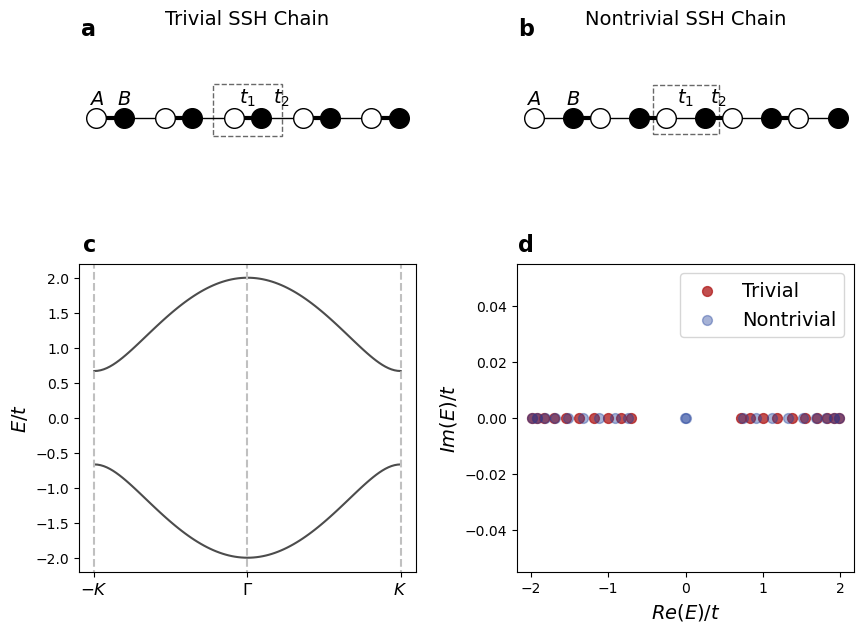

<Figure size 640x480 with 0 Axes>

In [14]:

# Parameters for the SSH chains
N = 10  # Number of atoms in the chain

# Bond lengths (representing hopping parameters)
l1_trivial = 0.8  # Strong bond (shorter bond within unit cell) for trivial chain
l2_trivial = 1.2  # Weak bond (longer bond between unit cells) for trivial chain

l1_nontrivial = 1.2  # Weak bond (longer bond within unit cell) for non-trivial chain
l2_nontrivial = 0.8  # Strong bond (shorter bond between unit cells) for non-trivial chain

# Generate positions for the trivial SSH chain
positions_trivial = [0]
for n in range(1, N):
    if n % 2 == 1:
        positions_trivial.append(positions_trivial[-1] + l1_trivial)
    else:
        positions_trivial.append(positions_trivial[-1] + l2_trivial)

# Generate positions for the non-trivial SSH chain
positions_nontrivial = [0]
for n in range(1, N):
    if n % 2 == 1:
        positions_nontrivial.append(positions_nontrivial[-1] + l1_nontrivial)
    else:
        positions_nontrivial.append(positions_nontrivial[-1] + l2_nontrivial)

# Define atom types (A and B)
atom_types = ['A' if n % 2 == 0 else 'B' for n in range(N)]

# Create figure and subplots using GridSpec
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 2, 2])  # Adjust height ratios

# Assign subplots to GridSpec positions
ax1 = fig.add_subplot(gs[0, 0])  # Panel a
ax2 = fig.add_subplot(gs[0, 1])  # Panel b
ax3 = fig.add_subplot(gs[1, 0])  # Panel c
ax4 = fig.add_subplot(gs[1, 1])  # Panel d

# Function to plot SSH chain
def plot_ssh_chain(ax, positions, chain_type):
    # Separate positions of A and B atoms
    positions_A = [positions[n] for n in range(N) if atom_types[n] == 'A']
    positions_B = [positions[n] for n in range(N) if atom_types[n] == 'B']

    # Plot atoms
    ax.scatter(positions_A, [0]*len(positions_A), s=200, facecolors='white', edgecolors='k', zorder=3)
    ax.scatter(positions_B, [0]*len(positions_B), s=200, facecolors='black', edgecolors='k', zorder=3)

    # Plot bonds and add labels
    for n in range(N - 1):
        x_values = [positions[n], positions[n + 1]]
        y_values = [0, 0]
        # Determine bond type
        if chain_type == 'trivial':
            if n % 2 == 0:
                linewidth = 3  # Strong bond within unit cell
                bond_label = r'$t_1$'
            else:
                linewidth = 1  # Weak bond between unit cells
                bond_label = r'$t_2$'
        else:
            if n % 2 == 0:
                linewidth = 1  # Weak bond within unit cell
                bond_label = r'$t_1$'
            else:
                linewidth = 3  # Strong bond between unit cells
                bond_label = r'$t_2$'
        # Plot the bond
        ax.plot(x_values, y_values, c='k', linewidth=linewidth)
        # Add bond label only for specific bonds in the middle unit cell
        if n == 4 or n == 5:  # Bonds within the highlighted unit cell
            midpoint = (positions[n] + positions[n + 1]) / 2
            ax.text(midpoint, 0.3, bond_label, fontsize=14, ha='center', va='bottom')
    # Label the first two atoms
    ax.text(positions[0], 0.3, r'$A$', fontsize=14, ha='center', va='bottom')
    ax.text(positions[1], 0.3, r'$B$', fontsize=14, ha='center', va='bottom')

    # Highlight the middle unit cell
    unit_cell_start = (positions[3]+positions[4])/2
    unit_cell_end = (positions[5]+positions[6])/2
    width = unit_cell_end - unit_cell_start
    rect = Rectangle((unit_cell_start, -0.5), width, 1.5, linewidth=1, edgecolor='dimgray', linestyle='--', facecolor='none')
    ax.add_patch(rect)

    # Set plot limits and remove axes
    ax.set_ylim(-1, 1.5)
    ax.set_xlim(positions[0] - 0.5, positions[-1] + 0.5)
    ax.set_aspect('equal', adjustable='datalim')
    ax.axis('off')

# Plot trivial SSH chain in subplot (a)
plot_ssh_chain(ax1, positions_trivial, 'trivial')
ax1.set_title('Trivial SSH Chain', fontsize=14)

# Plot non-trivial SSH chain in subplot (b)
plot_ssh_chain(ax2, positions_nontrivial, 'non-trivial')
ax2.set_title('Nontrivial SSH Chain', fontsize=14)

# First band structure (Trivial SSH model)
band1 = sisl.BandStructure(H, [[-0.5, 0.0, 0], [0., 0., 0], [0.5, 0.0, 0]], 100,
                           ['-K', r'$\Gamma$', 'K'])
eigsTriv = band1.apply.array.eig()
bandTriv = band1.lineark()
eigs_sortedTriv = np.sort(eigsTriv, axis=1)  # Sort eigenvalues at each k-point

for i in range(eigs_sortedTriv.shape[1]):  # Iterate over bands
    ax3.plot(bandTriv, eigs_sortedTriv[:, i].real, c='k', lw=1.5, alpha=0.7)

# Add labels and ticks to ax3
ax3.set_ylabel(r'$E/t$', fontsize=14)
ax3.set_xticks([0, 1.57, 3.14])
ax3.set_xticklabels(['$-K$', r'$\Gamma$', '$K$'], fontsize=12)

# Add vertical lines for high-symmetry points in ax3
ymin, ymax = ax3.get_ylim()
ax3.axvline(0, ymin, ymax, ls='--', color='silver')
ax3.axvline(1.57, ymin, ymax, ls='--', color='silver')
ax3.axvline(3.14, ymin, ymax, ls='--', color='silver')


# Combined eigenvalue scatter plots (Panels E and F)
#ax4.scatter(eigzOBCTriv.real, eigzOBCTriv.imag, color='firebrick', alpha=0.8, label='Trivial', s=50) #, edgecolors='k')

ax4.scatter(eR0.real, eR0.imag, color='firebrick', alpha=0.8, label='Trivial', s=50) #, edgecolors='k')
ax4.scatter(eR1.real, eR1.imag, color=(33/255, 64/255, 154/255), alpha=0.4, label='Nontrivial', s=50) #, edgecolors='k')
ax4.legend(fontsize=14)
ax4.set_xlabel('$Re(E)/t$', fontsize=14)
ax4.set_ylabel('$Im(E)/t$', fontsize=14)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Add panel labels
panel_labels = ['a', 'b', 'c', 'd']
axes = [ax1, ax2, ax3, ax4]
for ax, label in zip(axes, panel_labels):
    ax.text(0.05, 1.10, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Save and show the plot
plt.savefig('fig1_update1.pdf', dpi=800, bbox_inches='tight', format='pdf')
plt.show()

# Ensure eigzOBCTriv and eR1 are numpy arrays
eigzOBCTriv = np.array(eigzOBCTriv)
eR1 = np.array(eR1)

# Adjust layout
plt.tight_layout()
plt.show()
